## Battery Charging Model 
Inspired by "[2] Optimizing the operation of energy storage using a non-linear lithium-ion battery degradation model"

### Objective Functions 
1. Balances Revenue stream and Degradation (Multi-Objetive Optimization) \
$\zeta = \omega{R} - (1 - \omega)D$ \
$\boldsymbol{\omega}$ $\rightarrow$ weighting factor $[0 \rightarrow 1]$ \
$\boldsymbol{D} \rightarrow$ total degradation in market period $[Ah]$\
$\boldsymbol{R} \rightarrow revenue $ [\$]\
2. Aims to maximize revenue \
$R = \sum_t[\lambda_t \times (P_t^{dis,m} - P_t^{ch,m})]\times\Delta{T}$ \
$\boldsymbol{R} \rightarrow $ market clearing price $[\frac{\$}{Wh}]$\
$\boldsymbol{\lambda_t} \rightarrow revenue [dollars]$ \
$\boldsymbol{P_t^{dis,m}} \rightarrow$ max power input to battery in trading interval $[W]$ \
$\boldsymbol{P_t^{ch, m}} \rightarrow$ max power output to battery in trading interval $[W]$ \
$\boldsymbol{\Delta{T}} \rightarrow$ duration of trading interval $[hr]$ \
3. Aims to reduce degradation
$D = \sum_t{d_t}$\
$\boldsymbol{D} \rightarrow$ total degradation in market period $[Ah]$\
$\boldsymbol{d_t} \rightarrow$ total degradation incurred in each period $[Ah]$\



### Battery Updates
4. Updates the state of the battery\
${SOC} = {SOC}_{t-1} + \frac{(P_t^{dis,m} - P_t^{ch,m})\times\Delta{T}}{V_{nom}I_{1C}}$\
$\boldsymbol{SOC_t} \rightarrow$ state of charge, % measure of remaining capacity $[0 \rightarrow 100]$\
$\boldsymbol{P_t^{dis,m}} \rightarrow$ max power output to battery in trading interval $[W]$ \
$\boldsymbol{P_t^{ch, m}} \rightarrow$ max power input to battery in trading interval $[W]$ \
$\boldsymbol{\Delta{T}} \rightarrow$ duration of trading interval $[hr]$ \
$\boldsymbol{V_{nom}} \rightarrow$ nominal battery voltage $[V]$: The reported or reference voltage of the battery, $[4]$\
$\boldsymbol{I_{1C}} \rightarrow$ 1C Current $[A]$:s. A C-rate is a measure of the rate at which a battery is discharged relative to its
maximum capacity. A 1C rate means that the discharge current will discharge the entire
battery in 1 hour $[4]$

### Constraints on Battery Updates
5-6. These are constraints that limit the maximum power input and output and also ensure that battery is either charged or discharged in any time interval
$0 \leq P_t^{ch,b} \leq P_t^{ch, m} \times u_t$\
$0 \leq P_t^{dis,b} \leq P_t^{dis, m} \times (1 - u_t)$\
$u_t = \text{0 or 1} \rightarrow binary$\
$\boldsymbol{P_t^{dis,m}} \rightarrow$ max power output to battery in trading interval $[W]$ \
$\boldsymbol{P_t^{ch, m}} \rightarrow$ max power input to battery in trading interval $[W]$ \
\
$ P_t^{ch,b} = P_t^{ch, m}\eta$\
$ \eta P_t^{dis,b} = P_t^{dis, m}$
$ \eta > 0$
$\boldsymbol{P_t^{dis,m}} \rightarrow$ max power output to battery in trading interval $[W]$ \
$\boldsymbol{P_t^{ch, m}} \rightarrow$ max power input to battery in trading interval $[W]$ \

7. Sets boundary on SOC\
$0 \leq SOC_t \leq 100$ 
$\boldsymbol{SOC_t} \rightarrow$ state of charge, % measure of remaining capacity $[0 \rightarrow 100]$\


## Battery Class Definition

In [40]:
import numpy as np
import matplotlib.pyplot as plt


# Battery Class Definition Template
class Battery():
    # Defining global static class variables
    global SOC_x, cum_deg_y, i_x, psi_y
    
    # Cumulative degredation mapping manually determined based on fig 4 in the paper
    SOC_x = np.linspace(0.0, 100.0, num=11)
    cum_deg_y = np.array([0.0, 39.0, 47.0, 75.0, 75.0, 84.0, 101.0, 160.0, 269.0, 325.0, 372.0])
    
    # Psi scaling factor using experimental data to linearly interpolate depending on current
    i_x = np.array([0.0, 1.0, 2.0])
    psi_y = np.array([0.0, 1.0, 1.2956])
    
    
    # Initialize with instance variables for battery charging/degradation
    
    # SOC --> State of charge [represents measure of remaining capacity in percentage form]
    # V_nom --> Nominal Voltage [Volts]
    # P_ch_max --> Max power oup
    # charging --> boolen: True if charging, False if dissipating
    # eta --> Battery inefficiency constant (this is approximation from [2])
    def __init__(self):
        # Constants
        self.V_nom = 5           # [Volts] --> do research to determine starting value
        self.IC1 = 1             # [Variable] --> Can optimize during charging cycle
        self.P_ch_max = 1        # [Watt] --> do research to determine starting value
        self.P_dis_max = 1       # [Watt] --> do research to determine starting value
        self.eta = .95           # [Constant] Initial guess at inefficiency constant
        self.deltaT = 1          # [Hours] Duration of trading interval  
        
        # Variables
        self.SOC = 100           # [Percentage]
        self.SOC_prev = 100      # [Percentage]
        self.d_t1C = 1           # [Amp Hours] degredation at 1C charge during one time interval
        self.psi_t = 1           # [unitless] scaling factor of degredation depending on current
        self.d_t = 1             # [Amp Hours] 
        self.charging = False    # [Bool] Initialize as not charging
        self.P_ch_b = 0          # [Watt] current charge power input to battery
        self.P_dis_b = 0         # [Watt] current discharge power output from battery
        self.Q = 1e2             # [Amp Hours] Weighted Capacity of the battery

        
#     P_ch_b = P_ch_m * eta
#     P_dis_b = P_dis_m / eta
        
        
    def setSOC(self, val):
        if (val > 100 or val < 0):
            raise ValueError("SOC must be between 0 and 100")
        else:
            self.SOC = val
              
                
    def updateSOC(self):
        # Updates the SOC from one trading interval to the next    
        self.SOC_prev = self.SOC
        self.SOC = self.SOC_prev + (self.P_ch_b - self.P_dis_b)*self.deltaT / (self.V_nom * self.IC1)
        
        #Ensure that SOC lies in between 0 and 100 (constraint 7)
        self.SOC = max(0, self.SOC)
        self.SOC = min(100, self.SOC)
    
    
    def getD_t1C(self):
        # Calculate d_t1C = abs(delta_t - delta_t-1)
        delta1C = np.interp(self.SOC, SOC_x, cum_deg_y)
        delta1C_prev = np.interp(self.SOC_prev, SOC_x, cum_deg_y)
        d_t1C = np.abs(delta1C - delta1C_prev)
        self.d_t1C = d_t1C
    
    
    def plotCum_Deg(self):
        # Plots essentially the same plot as fig 4 in the paper
        plt.plot(SOC_x, cum_deg_y, marker='D')
        plt.xlabel("SOC (%)")
        plt.ylabel("Cumulative Degredation (10^-6 Ah)")
    
    
    def getPsi(self):
        # Calculate i_t and use to determine psi
        i_t = (self.P_ch_b + self.P_dis_b) / (self.V_nom * self.IC1)
        psi_t = np.interp(i_t, i_x, psi_y)
        self.psi_t = psi_t
    
    
    def getD_t(self):
        # Calculate d_t as a function of d_t1C and psi_t
        d_t = ((self.d_t1C + self.psi_t) / 2) ** 2 - ((self.d_t1C - self.psi_t) / 2) ** 2
        self.d_t = d_t
        
    def updateQ(self):
        self.Q -= self.d_t*self.psi_t*self.deltaT
    
    
        

Very minimal example of how to do equation 4

In [18]:
bat = Battery()
bat.setSOC(55.0) # Set the initial charge
powerCharged = 0 #W
powerDissipated = 10 #W
bat.P_ch_b = powerCharged
bat.P_dis_b = powerDissipated

print("Starting battery SOC: ", bat.SOC)
bat.updateSOC()
print("Updated battery SOC:  ", bat.SOC)

Starting battery SOC:  55.0
Updated battery SOC:   53.0


In [50]:
bat.getD_t1C()
bat.getPsi()
bat.getD_t()
print("Degredation at 1C current rate:      ", bat.d_t1C)
print("Scaling factor psi:                  ", bat.psi_t)
print("Degradation after one time interval: ", bat.d_t)

Degredation at 1C current rate:       3.4000000000000057
Scaling factor psi:                   1.2956
Degradation after one time interval:  4.459964840000011


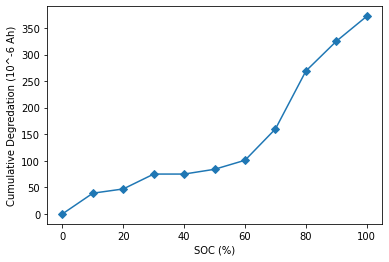

In [51]:
bat.plotCum_Deg()


### Example
Simple example to compare how battery degradation and life are related. Note, the beginning battery capacity in this example is extremely low for plotting purposes.

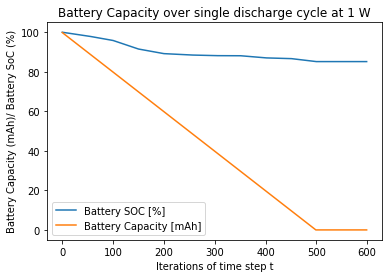

Note how it plateaus when the battery becomes completely discharged


In [57]:
bat = Battery()
bat.P_dis_b = bat.P_dis_max
bat_capacity_over_time = []
bat_percentage_over_time = []
n = 600
for i in range(n):
    bat.updateSOC()
    bat.getPsi()
    bat.getD_t1C()
    bat.getD_t()
    bat.updateQ()
    bat_capacity_over_time.append(bat.Q)
    bat_percentage_over_time.append(bat.SOC)

plt.xlabel("Iterations of time step t")
plt.ylabel("Battery Capacity (mAh)/ Battery SoC (%)")
plt.title("Battery Capacity over single discharge cycle at 1 W")
plt.plot(range(n), bat_capacity_over_time)
plt.plot(range(n), bat_percentage_over_time)
plt.legend({"Battery Capacity [mAh]", "Battery SOC [%]"})
plt.show()
print("Note how it plateaus when the battery becomes completely discharged")
